 # Results Analysis


 ## 🧰 Setups and Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.formula.api import mixedlm
from scipy import stats

# Load your data
df = pd.read_csv("laterality_results.csv")
df.head()


,subject,stage,split,event,LC
0,P2,post,training,left,0.459160
1,P2,post,training,right,0.273282
2,P2,post,training,left,-0.803730
3,P2,post,training,right,0.391912
4,P2,post,training,right,0.061469


## 📊 Distribution Overview

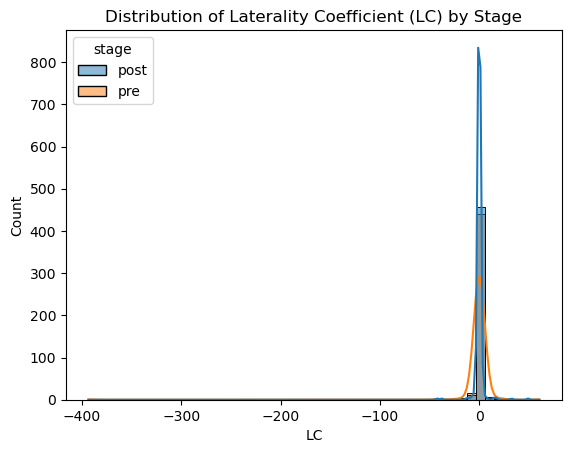

In [2]:
# General distribution of LC values
sns.histplot(data=df, x="LC", hue="stage", kde=True, bins=50)
plt.title("Distribution of Laterality Coefficient (LC) by Stage")
plt.show()


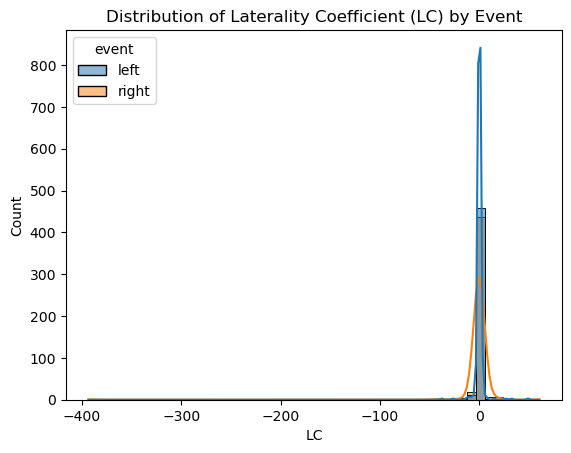

In [3]:
# General distribution of LC values
sns.histplot(data=df, x="LC", hue="event", kde=True, bins=50)
plt.title("Distribution of Laterality Coefficient (LC) by Event")
plt.show()


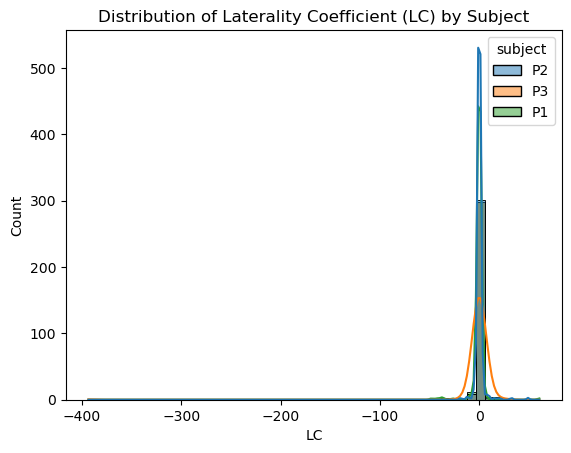

In [4]:
# General distribution of LC values
sns.histplot(data=df, x="LC", hue="subject", kde=True, bins=50)
plt.title("Distribution of Laterality Coefficient (LC) by Subject")
plt.show()


## 🧠 Subject-wise Paired Plot (Left vs Right)

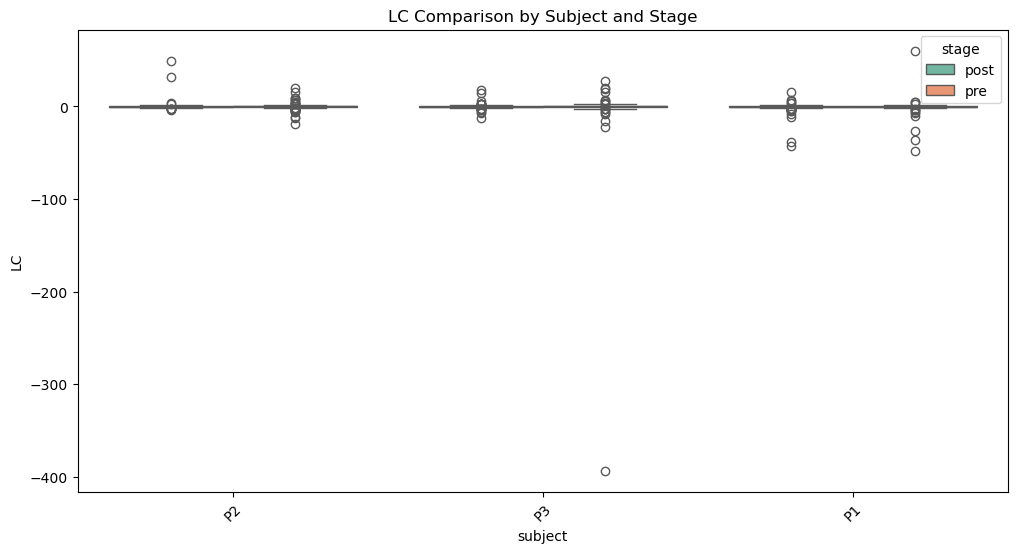

In [5]:
# Boxplot split by subject, event, and stage
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x="subject", y="LC", hue="stage", palette="Set2")
plt.title("LC Comparison by Subject and Stage")
plt.xticks(rotation=45)
plt.show()


## 📈 LC Change (Post - Pre)

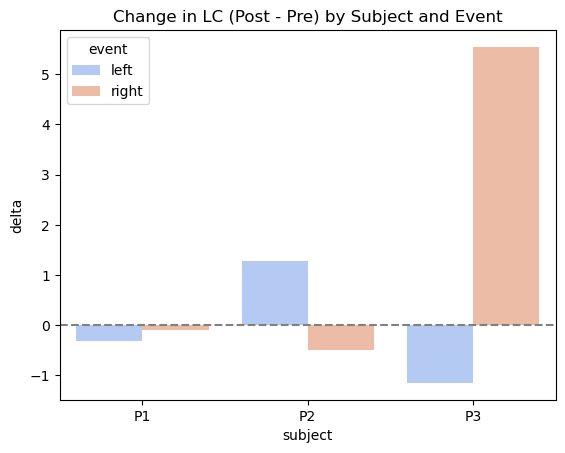

In [6]:
# Calculate per-subject delta LC
delta_df = df.pivot_table(index=['subject', 'event'], columns='stage', values='LC').reset_index()
delta_df['delta'] = delta_df['post'] - delta_df['pre']

sns.barplot(data=delta_df, x='subject', y='delta', hue='event', palette='coolwarm')
plt.axhline(0, linestyle='--', color='gray')
plt.title("Change in LC (Post - Pre) by Subject and Event")
plt.show()


## 🔬 Group-Level Analysis

/home/vcali/miniforge3/envs/sleep_stage_classification_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/vcali/miniforge3/envs/sleep_stage_classification_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/home/vcali/miniforge3/envs/sleep_stage_classification_env/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_349057/2981518757.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``

                 Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      LC        
No. Observations:       957          Method:                  REML      
No. Groups:             3            Scale:                   184.1017  
Min. group size:        318          Log-Likelihood:          -3854.3925
Max. group size:        320          Converged:               Yes       
Mean group size:        319.0                                           
------------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
------------------------------------------------------------------------
Intercept                     0.100    8.881  0.011 0.991 -17.306 17.507
stage[T.pre]                  0.052    1.240  0.042 0.967  -2.378  2.482
event[T.right]               -0.297    1.240 -0.239 0.811  -2.727  2.134
stage[T.pre]:event[T.right]  -1.681    1.754 -0.958 0.338  -5.120  1.

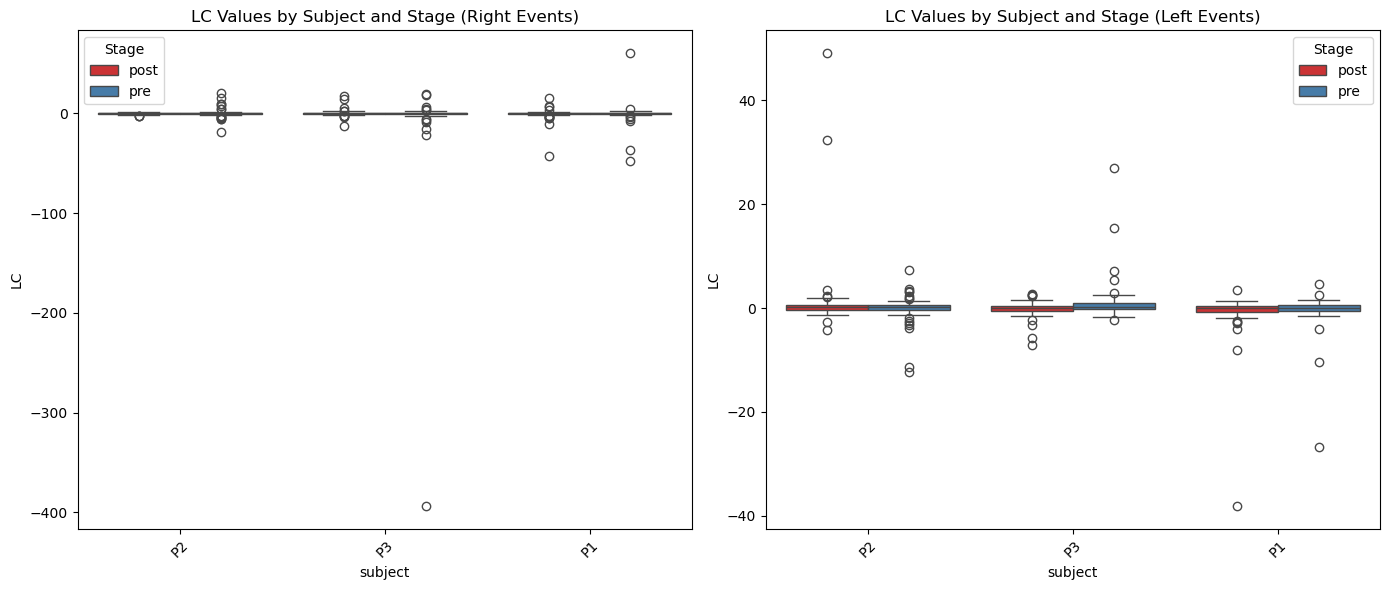

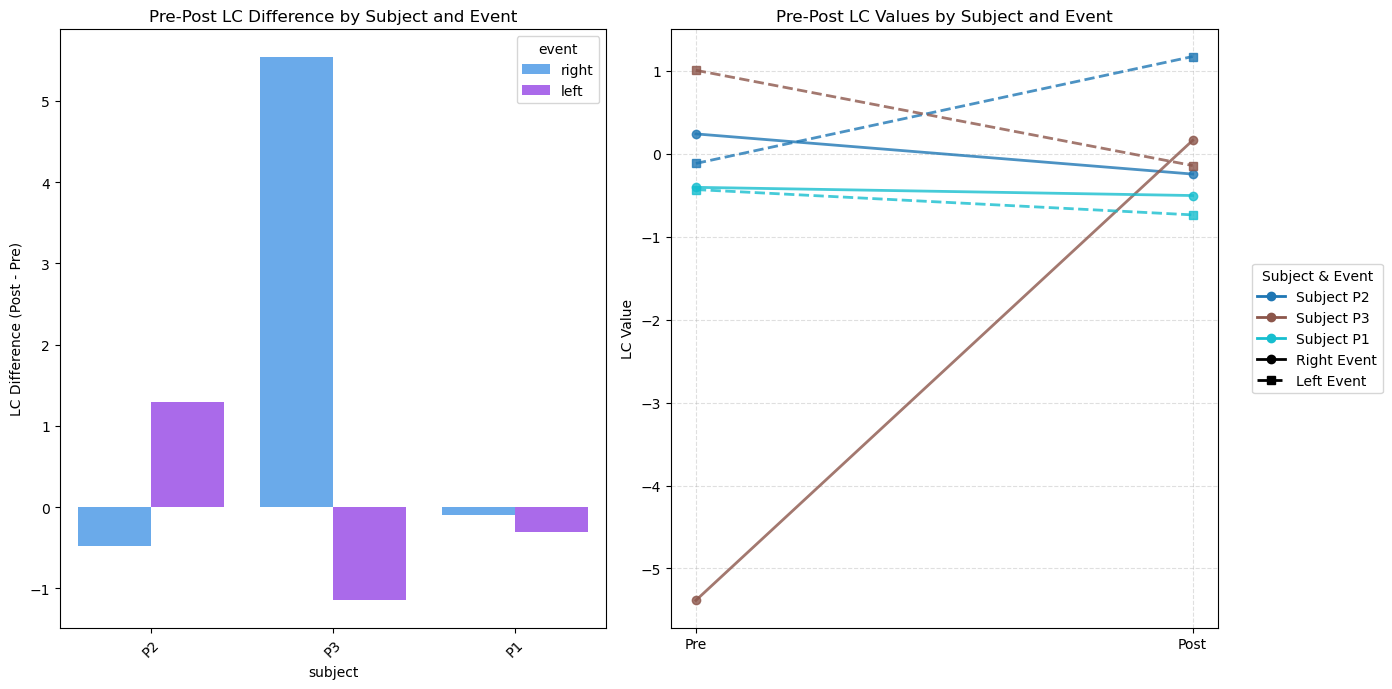

In [7]:
# Assuming you have your data in a DataFrame called 'df'
# with columns ['subject', 'stage', 'split', 'event', 'LC']

# 1. Exploratory Data Analysis
# ----------------------------

# Create visualization to compare pre vs post by event type
plt.figure(figsize=(14, 6))

# Create subplot for 'right' events
plt.subplot(1, 2, 1)
right_data = df[df['event'] == 'right']
sns.boxplot(x='subject', y='LC', hue='stage', data=right_data, palette='Set1')
plt.title('LC Values by Subject and Stage (Right Events)')
plt.xticks(rotation=45)
plt.legend(title='Stage')

# Create subplot for 'left' events
plt.subplot(1, 2, 2)
left_data = df[df['event'] == 'left']
sns.boxplot(x='subject', y='LC', hue='stage', data=left_data, palette='Set1')
plt.title('LC Values by Subject and Stage (Left Events)')
plt.xticks(rotation=45)
plt.legend(title='Stage')

plt.tight_layout()
plt.savefig('lc_boxplot.png')

# 2. Linear Mixed Effects Model
# -----------------------------

# Fit the mixed effects model
# Formula: LC ~ stage + event + stage:event + (1|subject)
# This tests for main effects of stage and event, plus their interaction,
# with a random intercept for each subject

model = mixedlm("LC ~ stage + event + stage:event", 
                data=df, 
                groups=df["subject"])
result = model.fit()
print(result.summary())

# 3. Post-hoc Analysis
# --------------------

# Compare pre vs post for each event type with paired t-tests
# (as a complementary analysis)

# For 'right' events
right_data = df[df['event'] == 'right']
# First aggregate by subject and stage to handle multiple measurements
right_agg = right_data.groupby(['subject', 'stage'])['LC'].mean().reset_index()
# Then pivot the aggregated data
right_pre_post = right_agg.pivot(index='subject', columns='stage', values='LC')
# Check if both 'pre' and 'post' columns exist and if there are enough subjects
if 'pre' in right_pre_post.columns and 'post' in right_pre_post.columns:
    # Drop rows with missing values (if a subject only has pre or post)
    right_pre_post = right_pre_post.dropna()
    if len(right_pre_post) >= 2:  # Need at least 2 subjects for a paired t-test
        t_right, p_right = stats.ttest_rel(right_pre_post['pre'], right_pre_post['post'])
        print(f"\nPaired t-test for 'right' events (pre vs post): t={t_right:.4f}, p={p_right:.4f}")
    else:
        print("\nNot enough complete data for paired t-test on 'right' events")
else:
    print("\nMissing 'pre' or 'post' data for 'right' events")

# For 'left' events
left_data = df[df['event'] == 'left']
# First aggregate by subject and stage to handle multiple measurements
left_agg = left_data.groupby(['subject', 'stage'])['LC'].mean().reset_index()
# Then pivot the aggregated data
left_pre_post = left_agg.pivot(index='subject', columns='stage', values='LC')
# Check if both 'pre' and 'post' columns exist and if there are enough subjects
if 'pre' in left_pre_post.columns and 'post' in left_pre_post.columns:
    # Drop rows with missing values (if a subject only has pre or post)
    left_pre_post = left_pre_post.dropna()
    if len(left_pre_post) >= 2:  # Need at least 2 subjects for a paired t-test
        t_left, p_left = stats.ttest_rel(left_pre_post['pre'], left_pre_post['post'])
        print(f"Paired t-test for 'left' events (pre vs post): t={t_left:.4f}, p={p_left:.4f}")
    else:
        print("Not enough complete data for paired t-test on 'left' events")
else:
    print("Missing 'pre' or 'post' data for 'left' events")

# 4. Effect Size Calculation
# -------------------------

# Calculate Cohen's d for each subject's pre-post difference
effect_sizes = []
subjects = df['subject'].unique()

for subject in subjects:
    subject_data = df[df['subject'] == subject]
    
    # For right events
    right_subj = subject_data[subject_data['event'] == 'right']
    pre_right = right_subj[right_subj['stage'] == 'pre']
    post_right = right_subj[right_subj['stage'] == 'post']
    
    if len(pre_right) > 0 and len(post_right) > 0:
        pre_mean = pre_right['LC'].mean()
        post_mean = post_right['LC'].mean()
        
        # Handle cases where there's only one measurement in pre or post
        pre_std = pre_right['LC'].std() if len(pre_right) > 1 else 0
        post_std = post_right['LC'].std() if len(post_right) > 1 else 0
        
        # Avoid division by zero
        if pre_std > 0 or post_std > 0:
            pooled_std = np.sqrt((pre_std**2 + post_std**2) / 2)
            cohen_d = (post_mean - pre_mean) / pooled_std if pooled_std > 0 else np.nan
            effect_sizes.append({'subject': subject, 'event': 'right', 'cohen_d': cohen_d})
    
    # For left events
    left_subj = subject_data[subject_data['event'] == 'left']
    pre_left = left_subj[left_subj['stage'] == 'pre']
    post_left = left_subj[left_subj['stage'] == 'post']
    
    if len(pre_left) > 0 and len(post_left) > 0:
        pre_mean = pre_left['LC'].mean()
        post_mean = post_left['LC'].mean()
        
        # Handle cases where there's only one measurement in pre or post
        pre_std = pre_left['LC'].std() if len(pre_left) > 1 else 0
        post_std = post_left['LC'].std() if len(post_left) > 1 else 0
        
        # Avoid division by zero
        if pre_std > 0 or post_std > 0:
            pooled_std = np.sqrt((pre_std**2 + post_std**2) / 2)
            cohen_d = (post_mean - pre_mean) / pooled_std if pooled_std > 0 else np.nan
            effect_sizes.append({'subject': subject, 'event': 'left', 'cohen_d': cohen_d})

effect_df = pd.DataFrame(effect_sizes)
if not effect_df.empty:
    print("\nCohen's d effect sizes by subject and event:")
    print(effect_df)
else:
    print("\nNot enough data to calculate Cohen's d effect sizes")

# 5. Visualization of Pre-Post Changes
# -----------------------------------

# Create a plot showing pre-post changes by subject and event
plt.figure(figsize=(14, 7))

# Prepare data for visualization
viz_data = []
for subject in subjects:
    for event in ['right', 'left']:
        subj_event_data = df[(df['subject'] == subject) & (df['event'] == event)]
        pre_data = subj_event_data[subj_event_data['stage'] == 'pre']['LC'].values
        post_data = subj_event_data[subj_event_data['stage'] == 'post']['LC'].values
        
        if len(pre_data) > 0 and len(post_data) > 0:
            viz_data.append({
                'subject': subject,
                'event': event,
                'pre': np.mean(pre_data),
                'post': np.mean(post_data),
                'difference': np.mean(post_data) - np.mean(pre_data)
            })

viz_df = pd.DataFrame(viz_data)

# Only proceed with visualization if we have data
if not viz_df.empty:
    # Plot the changes
    plt.subplot(1, 2, 1)
    sns.barplot(x='subject', y='difference', hue='event', data=viz_df, palette='cool')
    plt.title('Pre-Post LC Difference by Subject and Event')
    plt.ylabel('LC Difference (Post - Pre)')
    plt.xticks(rotation=45)

    # For the second plot, use unique colors for subjects and line styles for events
    plt.subplot(1, 2, 2)
    
    # Generate a color map for subjects
    unique_subjects = viz_df['subject'].unique()
    num_subjects = len(unique_subjects)
    
    # Create a colormap with distinct colors for each subject
    import matplotlib.cm as cm
    from matplotlib.colors import ListedColormap
    
    # Choose a colormap that will give distinct colors for the number of subjects
    if num_subjects <= 10:
        # For fewer subjects, use a qualitative colormap
        cmap = plt.cm.get_cmap('tab10', num_subjects)
    else:
        # For more subjects, use a colormap with more colors
        cmap = plt.cm.get_cmap('viridis', num_subjects)
        
    subject_to_color = {subject: cmap(i) for i, subject in enumerate(unique_subjects)}
    
    # Plot with subject-specific colors and event-specific line styles
    for subject in unique_subjects:
        subject_data = viz_df[viz_df['subject'] == subject]
        
        # Plot right event (solid line)
        right_row = subject_data[subject_data['event'] == 'right']
        if not right_row.empty:
            plt.plot([0, 1], [right_row.iloc[0]['pre'], right_row.iloc[0]['post']], 
                    marker='o', 
                    color=subject_to_color[subject],
                    linestyle='-',
                    linewidth=2,
                    alpha=0.8)
        
        # Plot left event (dashed line)
        left_row = subject_data[subject_data['event'] == 'left']
        if not left_row.empty:
            plt.plot([0, 1], [left_row.iloc[0]['pre'], left_row.iloc[0]['post']], 
                    marker='s',  # Square marker for left events
                    color=subject_to_color[subject],
                    linestyle='--',
                    linewidth=2,
                    alpha=0.8)
    
    plt.xticks([0, 1], ['Pre', 'Post'])
    plt.title('Pre-Post LC Values by Subject and Event')
    plt.ylabel('LC Value')
    plt.grid(True, linestyle='--', alpha=0.4)

    # Add a legend for line styles (events)
    from matplotlib.lines import Line2D
    event_legend_elements = [
        Line2D([0], [0], color='black', marker='o', linestyle='-', linewidth=2, label='Right Event'),
        Line2D([0], [0], color='black', marker='s', linestyle='--', linewidth=2, label='Left Event')
    ]
    
    # Add a legend for colors (subjects)
    subject_legend_elements = [
        Line2D([0], [0], color=subject_to_color[subject], marker='o', linestyle='-', 
               linewidth=2, label=f'Subject {subject}') 
        for subject in unique_subjects
    ]
    
    # Create two separate legends
    plt.legend(handles=event_legend_elements, loc='upper right', title='Event Type')
    
    # If there are many subjects, create a separate legend for subjects
    if num_subjects <= 10:
        # For fewer subjects, include the subject legend
        plt.legend(handles=subject_legend_elements + event_legend_elements, 
                loc='center left', bbox_to_anchor=(1.05, 0.5), title='Subject & Event')
    else:
        # For many subjects, just show event legend to avoid overcrowding
        plt.legend(handles=event_legend_elements, loc='upper right', title='Event Type')
        print("\nNote: Subject color legend omitted due to large number of subjects")

    plt.tight_layout()
    plt.savefig('pre_post_changes.png')
else:
    print("\nNot enough data for visualization of pre-post changes")

# 6. Interpretation Guidelines
# ---------------------------
print("\nInterpretation Guidelines:")
print("1. Check the mixed model p-values:")
print("   - Stage effect: Is there a significant difference between pre and post regardless of event?")
print("   - Event effect: Is there a significant difference between right and left events?")
print("   - Interaction: Does the pre-post difference depend on the event type?")
print("2. Examine the random effects to understand subject variability")
print("3. Check the paired t-test results for right and left events separately")
print("4. Look at Cohen's d values: <0.2 (negligible), 0.2-0.5 (small), 0.5-0.8 (medium), >0.8 (large)")
print("5. The visualizations show how consistent the changes are across subjects")